In [1]:
import os
import pathlib
import collections

import pandas as pd
from tqdm.auto import tqdm

import audiocap


tqdm.pandas()

def read_audioset_csv(csv_path, audios_root):
    split_name = pathlib.Path(csv_path).stem
    audios_dir = pathlib.Path(audios_root) / split_name
    df = pd.read_csv(
        csv_path,
        comment='#',
        sep=", ",
        engine='python',
        header=None,
        names=['youtube_id', 'start_seconds', 'end_seconds', 'labels'],
    )
    df = df[df["youtube_id"].apply(lambda x: os.path.exists(audios_dir / f'{x}.mp3'))]
    df["labels"] = df["labels"].str.strip('"').str.split(",")
    df["orig_split"] = split_name
    return df

audio_root = '../data/audioset_full/audios'
df = pd.concat([
    read_audioset_csv('../data/audioset_full/csvs/train_unbalanced.csv', audio_root),
    read_audioset_csv('../data/audioset_full/csvs/train_balanced.csv', audio_root),
    read_audioset_csv('../data/audioset_full/csvs/eval.csv', audio_root),
])
df.drop_duplicates(subset=["youtube_id"], inplace=True)
df.reset_index(drop=True, inplace=True)

len(df)

1770026

In [2]:
df.columns

Index(['youtube_id', 'start_seconds', 'end_seconds', 'labels', 'orig_split'], dtype='object')

In [3]:
ontology = audiocap.audioset_tools.AudiosetOntology.from_json_file('../data/audioset_full/csvs/ontology.json')

In [4]:
label_counts = (
    df["labels"]
    .explode()
    .map(ontology.df["name"].to_dict())
    .value_counts()
    .rename("count")
)

In [5]:
ontology.df[ontology.df.name.str.contains("Whip")]

,name,description,citation_uri,positive_examples,child_ids,restrictions
id,,,,,,
/m/07rbp7_,Whip,"The sound of whipping, i.e., the greatly accel...",http://wordnetweb.princeton.edu/perl/webwn?s=whip,"[youtu.be/LhbzdtNRTKs?start=30&end=40, youtu.b...",[],[]


In [7]:
ontology.audioset_label_ids_to_str("/m/012n7d, /g/11b630rrvh")

'emergency vehicle, siren, ambulance (siren), domestic sounds - home sounds, whistle, kettle whistle'

In [8]:
audiocap.metrics.keyword_metrics_batch(
    y_pred = ["hello, darkness, my old friend", "a, b, c, d, e"],
    y_true = ["hello, world,", "a, b, c, d"],
)

{'keywords_num_generated': 4.0,
 'keywords_num_true': 3.0,
 'keywords_precision': 0.5666666666666667,
 'keywords_recall': 0.75,
 'keywords_f1': 0.6444444444444445,
 'keywords_jaccard': 0.525}

In [9]:
df["labels"].explode().isin(ontology.df.index).all()

True

In [10]:
pd.options.plotting.backend = "plotly"

In [11]:
len(df["labels"].explode().value_counts())

527

In [12]:
(df["labels"].explode().value_counts() > 400).mean()

0.8292220113851992

In [13]:
music_overrepresented_general = {
    "Musical instrument",
    "Music genre",
}

desired_num_samples_per_class = {label: 500 for label in ontology.df.index}
for category in music_overrepresented_general:
    descendants = ontology.all_descendants(name=category, include_self=True)
    for label in descendants.index:
        desired_num_samples_per_class[label] = 80

pd.Series(desired_num_samples_per_class).value_counts()

500    474
80     158
dtype: int64

In [15]:
selector = audiocap.audioset_tools.AudiosetSubsetSelector(
    df=df,
    desired_num_samples_per_class=desired_num_samples_per_class,
    seed=42,
    step=100,
    ontology=ontology,
)

In [16]:
subset = selector.select_reasonable_subset()
len(subset)

  0%|          | 0/186875 [00:00<?, ?it/s]

134025

In [44]:
def label_word_freqs(*, labels_str=None, label_ids=None):
    freqs = collections.Counter()
    if labels_str is None:
        labels_str = map(ontology.audioset_label_ids_to_str, label_ids)
        length = len(label_ids)
    else:
        length = len(labels_str)
        
    for label_str in tqdm(labels_str, desc="label word frequencies", total=length):
        label_str = "".join([c if c.isalnum() else " " for c in label_str.lower()])
        freqs.update(label_str.split())
    return freqs

In [45]:
subset.sample(30, random_state=42)["labels"].apply(ontology.audioset_label_ids_to_str, include_parents=True).tolist()

['truck, reversing beeps, motor vehicle (road), sounds of things, vehicle, human voice, speech',
 'door, generic impact sounds, tap',
 'mechanisms, mechanical fan',
 'heart sounds - heartbeat, heart murmur',
 'music, noise, cacophony',
 'respiratory sounds, cough',
 'music genre, jazz',
 'human voice, singing, yodeling, music, male singing',
 'fowl, turkey, livestock - farm animals - working animals, gobble',
 'alarm, fire alarm',
 'music, guitar, steel guitar - slide guitar',
 'natural sounds, fire, wind, microphone, wind noise (microphone)',
 'livestock - farm animals - working animals, fowl, goose, honk',
 'wild animals, canidae - dogs - wolves, animal, domestic animals - pets, dog, bow-wow',
 'music genre, folk music',
 'music, music role, lullaby',
 'music, classical music, opera, singing, female singing, synthetic singing',
 'electronic music, drum and bass, electronica',
 'music role, lullaby',
 'speech, male speech - man speaking',
 'livestock - farm animals - working animals, 

In [46]:
import wordcloud 

freqs = label_word_freqs(label_ids=subset["labels"])

label word frequencies:   0%|          | 0/134025 [00:00<?, ?it/s]

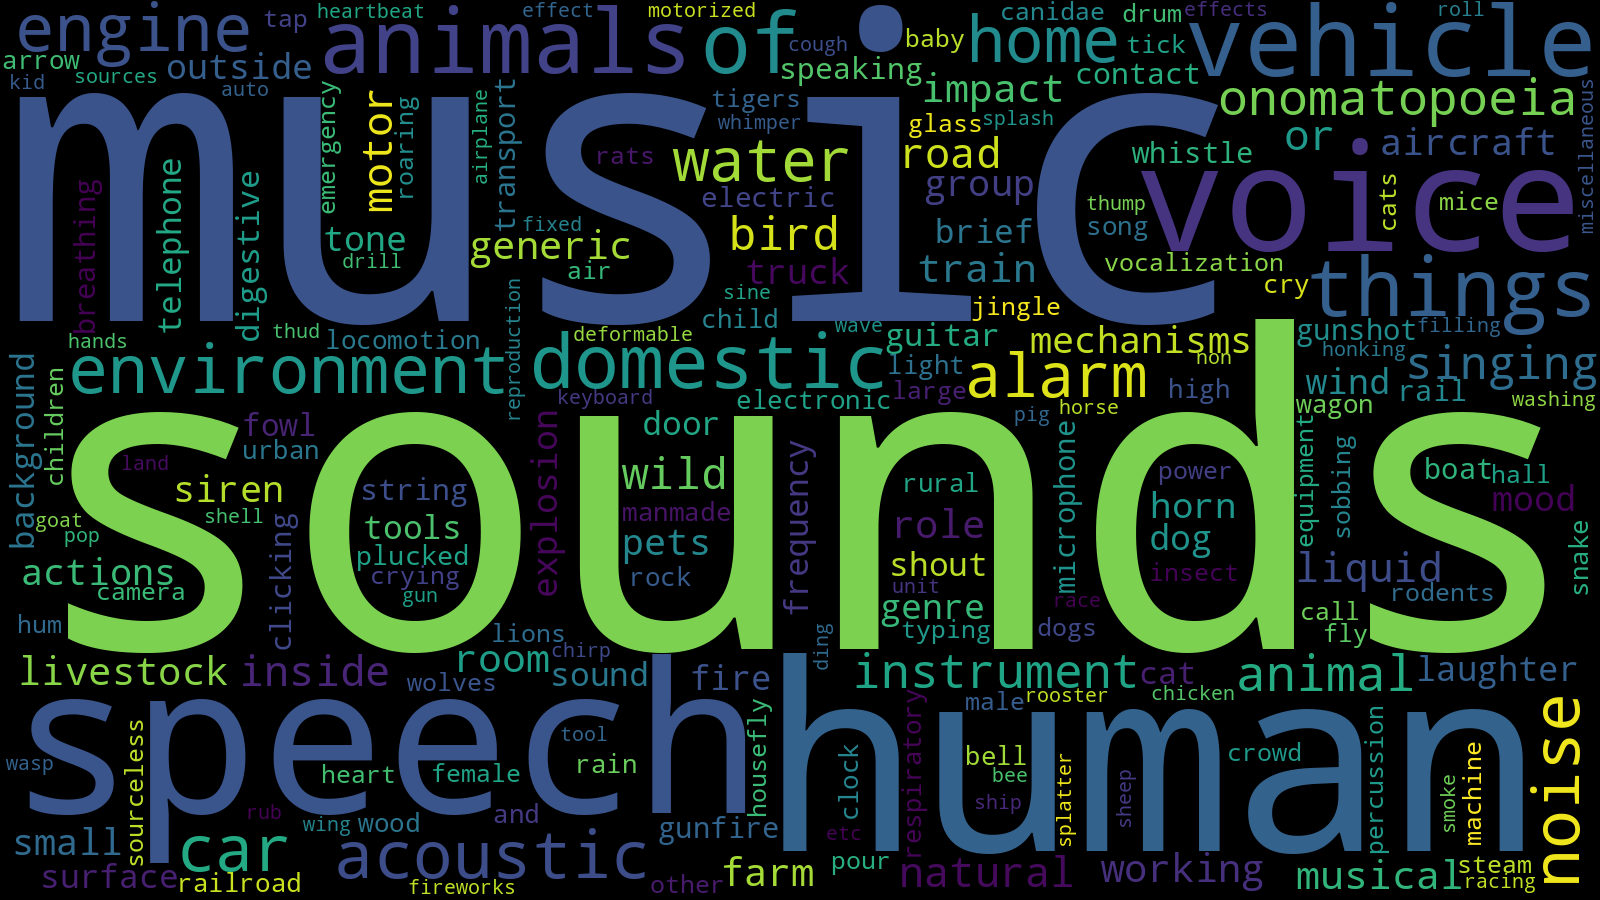

In [47]:
wordcloud.WordCloud(width=1600, height=900).generate_from_frequencies(freqs).to_image()

In [48]:
import numpy as np
import scipy.stats
import plotly.express

def print_subset_info(
    df_all: pd.DataFrame,
    subset: pd.DataFrame,
    ontology: audiocap.audioset_tools.AudiosetOntology,
    show_histogram: bool = True,
) -> None:
    total_counts = df_all["labels"].explode().value_counts()
    value_counts = subset["labels"].explode().value_counts()
    value_counts.index = value_counts.index.map(ontology.df["name"])
    entropy = scipy.stats.entropy(value_counts / value_counts.sum())
    print(f"Number of covered labels: {len(value_counts)} / total {len(total_counts)}")
    print(f"Entropy: {entropy:.4f}. Max entropy: {np.log(len(total_counts)):.4f}")
    print(f"Number of examples: {len(subset)}")
    value_counts.plot(kind="bar", title="Label Distribution").update_xaxes(tickangle=45).update_layout(showlegend=False).show()
    # create histogram of label counts
    if show_histogram:
        nbins = max(value_counts)//100+1
        plotly.express.histogram(value_counts, title="Label counts histogram", nbins=nbins).update_layout(showlegend=False).show()

In [49]:
print_subset_info(df, subset, ontology)

Number of covered labels: 527 / total 527
Entropy: 5.5940. Max entropy: 6.2672
Number of examples: 134025


In [50]:
value_counts = subset["labels"].explode().value_counts()
# Check how many examples consist only of labels that are represented a lot
subset["labels"].sample(10000, random_state=0).apply(lambda labels: all(value_counts[label] > 700 for label in labels)).mean()

0.0108

In [51]:
labels_str_sample = (
    subset["labels"]
    .sample(20000, random_state=0)
    .apply(ontology.audioset_label_ids_to_str, include_parents=True)
)

In [52]:
labels_str_sample.str.contains("speech").mean()

0.16805

In [53]:
labels_str_sample.str.contains("music").mean()

0.1865

In [54]:
labels_str_sample.str.contains(r"(music)|(speech)", regex=True).mean()

/tmp/ipykernel_1177523/28047695.py:1: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



0.3368

In [70]:
train_subset, test_subset = audiocap.audioset_tools.balanced_split(subset, minimum_test_examples_per_class=5, seed=9)
train_subset, valid_subset = audiocap.audioset_tools.balanced_split(train_subset, minimum_test_examples_per_class=5, seed=5)

In [56]:
assert train_subset["youtube_id"].is_unique
assert valid_subset["youtube_id"].is_unique
assert test_subset["youtube_id"].is_unique

assert len(train_subset) + len(valid_subset) + len(test_subset) == len(subset)
assert train_subset["youtube_id"].isin(valid_subset["youtube_id"]).sum() == 0
assert train_subset["youtube_id"].isin(test_subset["youtube_id"]).sum() == 0
assert valid_subset["youtube_id"].isin(test_subset["youtube_id"]).sum() == 0


In [71]:
len(train_subset), len(valid_subset), len(test_subset)

(128811, 2604, 2610)

In [73]:
print_subset_info(df, test_subset, ontology, show_histogram=False)

Number of covered labels: 527 / total 527
Entropy: 5.7161. Max entropy: 6.2672
Number of examples: 2610


In [74]:
print_subset_info(df, valid_subset, ontology, show_histogram=False)

Number of covered labels: 527 / total 527
Entropy: 5.6911. Max entropy: 6.2672
Number of examples: 2604


In [32]:
train_subset.columns

Index(['index', 'youtube_id', 'start_seconds', 'end_seconds', 'labels',
       'orig_split', 'selected', 'contains_music', 'contains_speech',
       'contains_no_music_or_speech', 'contains_music_xor_speech',
       'contains_music_and_speech'],
      dtype='object')

In [75]:
export_columns = ["youtube_id", "start_seconds", "end_seconds", "labels", "orig_split"]
train_subset[export_columns].to_json("train.jsonl", orient="records", lines=True, force_ascii=False)
valid_subset[export_columns].to_json("valid.jsonl", orient="records", lines=True, force_ascii=False)
test_subset[export_columns].to_json("test.jsonl", orient="records", lines=True, force_ascii=False)

In [ ]:
# these files were put in the data/audioset_small/annotaitons folder and committed to the repo
# now, they can be used to create the audiofolder